In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os
import random

%matplotlib inline

In [2]:
import torch
from torchvision import transforms
from torchvision.datasets import MNIST, CIFAR10


# MNIST
def mnist(batch_sz):
    num_classes = 10
    transform_train = transforms.Compose([
                        transforms.RandomCrop(28, padding=4),
                        transforms.RandomHorizontalFlip(),
                        transforms.ToTensor(),
                    ])
    transform_test = transforms.Compose([
                        transforms.ToTensor(),
                    ])

    # Training dataset
    train_data = MNIST(root='./datasets', train=True, download=True, transform=transform_train)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_sz, shuffle=True,pin_memory=True)

    # Test dataset
    test_data = MNIST(root='./datasets', train=False, download=True, transform=transform_test)
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_sz, shuffle=False, pin_memory=True)

    return train_loader, test_loader, num_classes


# CIFAR10
def cifar10(batch_sz):
    num_classes = 10
    transform_train = transforms.Compose([
                        transforms.RandomCrop(32, padding=4),
                        transforms.RandomHorizontalFlip(),
                        transforms.ToTensor(),
                    ])
    transform_test = transforms.Compose([
                        transforms.ToTensor(),
                    ])

    # Training dataset
    train_data = CIFAR10(root='./datasets', train=True, download=True, transform=transform_train)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_sz,
                                               shuffle=True, pin_memory=True)

    # Test dataset
    test_data = CIFAR10(root='./datasets', train=False, download=True, transform=transform_test)
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_sz, shuffle=False, pin_memory=True)

    return train_loader, test_loader, num_classes

In [3]:
train_loader,test_loader,_=mnist(5) # this is batch size i.e. the number of rows in a batch of data

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



In [ ]:
for i,batch in enumerate(train_loader):
  if i > 0:
    break
  x=batch[0]
  y=batch[1]
  print(type(x))
  print(x.shape)
  print(y.shape)

<class 'torch.Tensor'>
torch.Size([5, 1, 28, 28])
torch.Size([5])


In [ ]:
#Q1: define a 2 layer simple NN for mnist digit classificaiton

In [35]:
class Net(nn.Module):

  def __init__(self, input, hid1, output):
    super(Net, self).__init__()
    self.w1 = nn.Linear(input, hid1)
    self.w2 = nn.Linear(hid1, output)
    self.relu = nn.ReLU()

  def forward(self, x):
    out = self.w1(x)
    print(x.shape)
    out = self.relu(out)
    out = self.w2(out)
    out = self.relu(out)
    return out


In [ ]:
#Q2: Define a CNN with 2 conv layer and 2 linear layers for mnist digit communication

In [34]:
class ConvNet(nn.Module):

  def __init__(self):
    super(ConvNet,self).__init__()

    self.feature=nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,stride=1,padding=1),#size=28+2-2=28
        nn.BatchNorm2d(num_features=32),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,stride=1,padding=1),#size=28+2-2=28
        nn.BatchNorm2d(num_features=32),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(stride=2,kernel_size=2)#size=28*28/4=14*14
    )

    self.linear=nn.Sequential(
        nn.Linear(32*14*14,256),
        nn.BatchNorm1d(256),
        nn.ReLU(inplace=True),
        nn.Linear(256,10),
        nn.Softmax()
    )

  def forward(self, x):
    x=self.feature(x)
    print(x.shape)
    x=x.view(x.size(0),-1)
    print(x.shape)
    x=self.linear(x)
    print(x)
    return x


In [ ]:
#Q3: Train both networks for 10 epochs and compare their performance 

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [11]:
def seed_torch(seed=1029):
	random.seed(seed)
	os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
	np.random.seed(seed)
	torch.manual_seed(seed)
	torch.cuda.manual_seed(seed)
	torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
	torch.backends.cudnn.benchmark = False
	torch.backends.cudnn.deterministic = True

In [12]:
seed_torch()

In [37]:
net=Net(784, 100, 1)
net.cuda()
ls=[]
l_func = nn.MSELoss().cuda()
optim = torch.optim.Adagrad(net.parameters(), lr=0.005, lr_decay=0, weight_decay=0)

In [38]:
for i in range(10):
  L=0
  for batch in train_loader:
    x=batch[0].squeeze().view(5,784).float()
    x=x.cuda()
    y=batch[1].view(5,1).float()
    y=y.cuda()
    optim.zero_grad()
    loss=l_func(net.forward(x), y)
    loss.backward()
    optim.step()
    L+=loss
    
  ls.append(L)

流式输出内容被截断，只能显示最后 5000 行内容。
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
torch.Size([5, 784])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
torch.Size([5, 784])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
torch.Size([5, 784])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
torch.Size([5, 784])
tensor([[0., 0., 

tensor(38695.2031, device='cuda:0', grad_fn=<AddBackward0>)


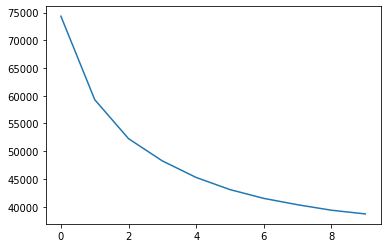

In [39]:
plt.plot(ls)
print(ls[-1])

In [40]:
convnet=ConvNet()
convnet=convnet.cuda()
criterion=nn.CrossEntropyLoss().cuda()
optimizer=torch.optim.Adam(convnet.parameters(), lr=0.005)
ls2=[]

In [41]:
for i in range(10):
  L=0
  for batch in train_loader:
    x=batch[0].float()
    x=x.cuda()
    y=batch[1]
    y=y.cuda()
    yhat=convnet.forward(x)
    loss=criterion(yhat,y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    L+=loss

  ls2.append(L)

torch.Size([5, 32, 14, 14])
torch.Size([5, 6272])
tensor([[0.0674, 0.0713, 0.0874, 0.1981, 0.0483, 0.0369, 0.1218, 0.0390, 0.2037,
         0.1261],
        [0.1096, 0.0937, 0.0676, 0.1658, 0.0653, 0.1288, 0.1039, 0.0616, 0.1470,
         0.0566],
        [0.0970, 0.1015, 0.0710, 0.1910, 0.0861, 0.0374, 0.0550, 0.0853, 0.1100,
         0.1658],
        [0.1118, 0.0641, 0.0436, 0.1965, 0.0659, 0.1684, 0.0719, 0.0660, 0.1303,
         0.0815],
        [0.0484, 0.0905, 0.0370, 0.2033, 0.0631, 0.0824, 0.0395, 0.0491, 0.1812,
         0.2055]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
torch.Size([5, 32, 14, 14])
torch.Size([5, 6272])
tensor([[0.0259, 0.0254, 0.0470, 0.6771, 0.0503, 0.0351, 0.0322, 0.0223, 0.0523,
         0.0324],
        [0.0829, 0.0461, 0.0155, 0.1264, 0.0235, 0.0244, 0.0240, 0.4923, 0.0765,
         0.0883],
        [0.0471, 0.0527, 0.0815, 0.4240, 0.1409, 0.0463, 0.0433, 0.0148, 0.1067,
         0.0425],
        [0.0368, 0.0487, 0.2572, 0.2491, 0.0217, 0.0919, 0.058

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


流式输出内容被截断，只能显示最后 5000 行内容。
         0.0000e+00, 1.3800e-31, 0.0000e+00, 0.0000e+00]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
torch.Size([5, 32, 14, 14])
torch.Size([5, 6272])
tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.2107e-15,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 7.9888e-42],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
torch.Size([5, 32, 14, 14])
torch.Size([5, 6272])
tensor([[0.000

tensor(19630.9551, device='cuda:0', grad_fn=<AddBackward0>)


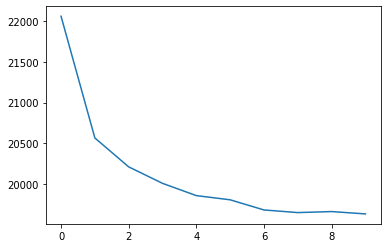

In [42]:
plt.plot(ls2)
print(ls2[-1])

In [ ]:
#Q4: Compare the accuarcay of both networks on the test set

In [19]:
net.eval()#预测模式
convnet.eval()
loss_nn=0
loss_cnn=0
correct_nn=0
correct_cnn=0
i=0

with torch.no_grad():
  for batch in test_loader:
    x=batch[0].squeeze().view(5,784).float()
    x=x.cuda()
    y=batch[1].view(5,1).float()
    y=y.cuda()
    yhat=net.forward(x)
    loss=l_func(yhat, y)
    loss_nn+=loss
    pred=yhat.round()
    correct_nn+=pred.eq(y.detach().view_as(pred)).cpu().sum()

loss_nn/=len(test_loader)


with torch.no_grad():
  for batch in test_loader:
    x=batch[0].float()
    x=x.cuda()
    y=batch[1]
    y=y.cuda()
    yhat=convnet.forward(x)
    loss=criterion(yhat,y)
    loss_cnn+=loss
    pred=yhat.detach().max(1,keepdim=True)[1]
    correct_cnn+=pred.eq(y.detach().view_as(pred)).cpu().sum()

loss_cnn/=len(test_loader)

print('Loss of NN:{:.3f} Num of correct: {}/{} ({:.3f}%)\n'.format(loss_nn,correct_nn,len(test_loader)*5,(correct_nn*100/(len(test_loader)*5))))
print('Loss of CNN:{:.3f} Num of correct: {}/{} ({:.3f}%)\n'.format(loss_cnn,correct_cnn,len(test_loader)*5,(correct_cnn*100/(len(test_loader)*5))))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Loss of NN:2.742 Num of correct: 2525/10000 (25.250%)

Loss of CNN:1.536 Num of correct: 9250/10000 (92.500%)



In [ ]:
#Q5: go through the testset and plot some samples of incorrect results

tensor([7.], device='cuda:0')
tensor([6.], device='cuda:0')


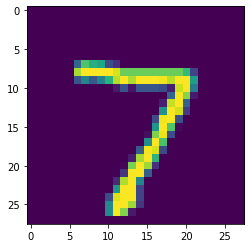

In [30]:
i=0
with torch.no_grad():
  for batch in test_loader:
    if i > 0:
      break
    else:
      i+=1
    xx=batch[0]
    x=xx.squeeze().view(5,784).float()
    x=x.cuda()
    y=batch[1].view(5,1).float()
    y=y.cuda()
    yhat=net.forward(x)
    loss=l_func(yhat, y)
    loss_nn+=loss
    pred=yhat.round()
    j=0
    for n in pred:
      if n.eq(y[j].detach().view_as(n)):
        n=n
      else:
        print(y[j].detach().view_as(n))
        print(n)
        plt.imshow(xx[j,0,:,:])
        break
      j+=1

tensor([3], device='cuda:0')
tensor([1], device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


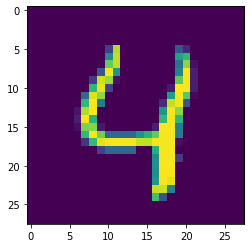

In [33]:
with torch.no_grad():
  for batch in test_loader:
    if i > 50:
      break
    else:
      i+=1
    x=batch[0].float()
    x=x.cuda()
    y=batch[1]
    y=y.cuda()
    yhat=convnet.forward(x)
    loss=criterion(yhat,y)
    loss_cnn+=loss
    pred=yhat.detach().max(1,keepdim=True)[1]
    correct_cnn+=pred.eq(y.detach().view_as(pred)).cpu().sum()
    j=0
    for n in pred:
      if n.eq(y[j].detach().view_as(n)):
        n=n
      else:
        print(y[j].detach().view_as(n))
        print(n)
        plt.imshow(xx[j,0,:,:])
        i=900
        break
      j+=1

In [ ]:
#Q6: show the output of the intermediate layers

In [43]:
net.eval()#预测模式
convnet.eval()
loss_nn=0
loss_cnn=0
correct_nn=0
correct_cnn=0
i=0

with torch.no_grad():
  for batch in test_loader:
    x=batch[0].squeeze().view(5,784).float()
    x=x.cuda()
    y=batch[1].view(5,1).float()
    y=y.cuda()
    yhat=net.forward(x)
    loss=l_func(yhat, y)
    loss_nn+=loss
    pred=yhat.round()
    correct_nn+=pred.eq(y.detach().view_as(pred)).cpu().sum()

loss_nn/=len(test_loader)


with torch.no_grad():
  for batch in test_loader:
    x=batch[0].float()
    x=x.cuda()
    y=batch[1]
    y=y.cuda()
    yhat=convnet.forward(x)
    loss=criterion(yhat,y)
    loss_cnn+=loss
    pred=yhat.detach().max(1,keepdim=True)[1]
    correct_cnn+=pred.eq(y.detach().view_as(pred)).cpu().sum()

loss_cnn/=len(test_loader)

print('Loss of NN:{:.3f} Num of correct: {}/{} ({:.3f}%)\n'.format(loss_nn,correct_nn,len(test_loader)*5,(correct_nn*100/(len(test_loader)*5))))
print('Loss of CNN:{:.3f} Num of correct: {}/{} ({:.3f}%)\n'.format(loss_cnn,correct_cnn,len(test_loader)*5,(correct_cnn*100/(len(test_loader)*5))))

流式输出内容被截断，只能显示最后 5000 行内容。
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
torch.Size([5, 784])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
torch.Size([5, 784])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
torch.Size([5, 784])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
torch.Size([5, 784])
tensor([[0., 0., 

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


流式输出内容被截断，只能显示最后 5000 行内容。
         1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]], device='cuda:0')
torch.Size([5, 32, 14, 14])
torch.Size([5, 6272])
tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         8.9543e-43, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]], device='cuda